# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write vectorized code whenever possible.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in the provided `hw2.py` python module only. All the logic you write is imported and used in this jupyter notebook.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports detected in `hw2.py` will earn you the grade of 0, even if you only used them for testing.
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install. Changes of the configuration we provided are at your own risk. Code that cannot run will also earn you the grade of 0.
7. Write your own code. Cheating will not be tolerated. 
8. Submission includes the `hw2.py` file and this notebook. Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).
9. You are allowed to include additional functions.
10. Submission: zip only the completed jupyter notebook and the python file `hw2.py`.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Implement a decision tree from scratch.
4. Prune the tree to achieve better results.
5. Visualize your results and the tree.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decision_trees import * # this imports all functions from hw2.

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

## Data preprocessing

We will use the breast cancer dataset that is available as a part of sklearn - a popular machine learning and data science library in python. In this example, our dataset will be a single matrix with the **labels on the last column**. Notice that you are not allowed to use additional functions from sklearn.

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# load dataset
X, y = datasets.load_breast_cancer(return_X_y = True)
X = np.column_stack([X,y]) # the last column holds the labels

# split dataset
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (426, 31)
Testing dataset shape:  (143, 31)


## Impurity Measures

Implement the functions `calc_gini` and `calc_entropy` in the python file `hw2.py`. You are encouraged to test your implementation using the cell below. We'll denote S as the dataset and $\phi$ as the impurity measure.

The Gini Impurity can be calculated by 
$$\phi(S) = 1 - \sum_{i=1}^{c}(p_i)^2 = 1 - \sum_{i=1}^{c} (\frac{|S_i|}{|S|})^2$$

and the Shannon Entropy can be calculated by
$$\phi(S) = -\sum_{i=1}^{c}p_i\log_2(p_i) = -\sum_{i=1}^{c}\frac{|S_i|}{|S|}\log_2(\frac{|S_i|}{|S|})$$

where $|S_i|$ is the size of class $i$ in the dataset $S$

In [3]:
equally_distributed_data = np.array([[1],[0],[1],[0]])
gini_impurity = calc_gini(equally_distributed_data)
print('✓' if np.equal(gini_impurity, 0.5) else '✗')

✓


In [4]:
shannon_entropy = calc_entropy(equally_distributed_data)
print('✓' if np.equal(shannon_entropy, 1) else '✗')

✓


## Splitting the data

Before we start building the decision tree we need a few metrics for splitting the data.

1. Since the data consists of continuous values. We will split the dataset according to a certain threshold. The dataset will be split into two according to every row where the specific feature is smaller than the threshold and larger than the threshold.
    - The thresholds will be calculated as the average of every consecutive pair in a vector. For example if the vector looks like [1,2,3,4,5] then the thresholds will be [1.5, 2.5, 3.5, 4.5]. 
2. Once we have all the thresholds for a certain feature we need to find the threshold that splits the data the best.
    - The best threshold is the one that maximizes the equation
    
    $$
    \phi(S,A) = \phi(S) - \sum_{v \in Values(A)}\frac{|S_v|} {|S|} \phi(S_v)
    $$
    
        where S is the dataset, A is the feature to split by, and Values(A) are the different classes of the dataset
        which is 0 and 1 in our case.
    - We choose the feature we want to split by, split the data according to each possible threshold and keep the    threshold with the best information .gain
3. Once we are able to find the best threshold for each feature, we need to find the best feature to split the data by. 
    - The best feature is the one that maximizes the same equation.

In [5]:
# Test for best_threshold
A = np.array([7,12,0,15,6])
A_labels = np.array([1,1,0,1,0])
A = np.column_stack((A, A_labels))
A
# Notice every row where the 0th feature is < 6.5 has a label of 0
# and every row where it's > 6.5 has a label of 1.
# So the threshold 6.5 splits the data perfectly.

array([[ 7,  1],
       [12,  1],
       [ 0,  0],
       [15,  1],
       [ 6,  0]])

In [6]:
# We'll find the best threshold for the only feature
best_threshold(A, 0, calc_entropy)

6.5

In [7]:
# Now we'll add more features to A and compute the best feature to split it by
A = np.column_stack((np.random.randint(0, 20, (5,3)), A))
A

array([[ 6, 19, 14,  7,  1],
       [10,  7,  6, 12,  1],
       [18, 10, 10,  0,  0],
       [ 3,  7,  2, 15,  1],
       [ 1, 11,  5,  6,  0]])

In [8]:
# Note the feature index is 0 relative. Look at the output and convince yourself that it makes sense.
feature, threshold = best_feature_threshold(A, calc_gini)
print(f"The best feature is feature #{feature}. The best associated threshold is {threshold}")

The best feature is feature #3. The best associated threshold is 6.5


## Building a Decision Tree

Use a Python class to construct the decision tree (look at the `DecisionNode` class in the python file `hw2.py`. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes continuous data. In this exercise, create at most a single split for each node of the tree. The threshold you need to use for this exercise are the average of each consecutive pair of values. For example, assume some features contains the following values: [1,2,3,4,5]. You should use the following thresholds [1.5, 2.5, 3.5, 4.5]. 
4. When constructing the tree, test all possible thresholds for each feature. The stopping criteria is a pure tree.

Complete the class `DecisionNode` in the python file `hw2.py`. The structure of this class is entirely up to you. Complete the function `build_tree` in the python file `hw2.py`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class.

In [14]:
%%time
# python support passing a function as arguments to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini, chi_value=1) 
tree_entropy = build_tree(data=X_train, impurity=calc_entropy, chi_value=1)

CPU times: user 17.3 s, sys: 147 ms, total: 17.5 s
Wall time: 17.7 s


## Tree evaluation

Complete the functions `predict` and `calc_accuracy` in the python file `hw2.py`. You are allowed to implement this functionality as a class method.

After building both trees using the training set (using Gini and Entropy as impurity measures), you should calculate the accuracy on the test set and print the measure that gave you the best test accuracy. For the rest of the exercise, use that impurity measure.

In [15]:
#### test predict function ####
instance = X_train[0]
label = instance[-1]

prediction = predict(tree_gini, instance)
print('✓' if np.equal(prediction, label) else '✗')

✓


In [16]:
gini_accuracy = calc_accuracy(tree_gini, X_test)
entropy_accuracy = calc_accuracy(tree_entropy, X_test)

print(f"Gini accuracy = {gini_accuracy:.2f}\nEntropy accuracy = {entropy_accuracy:.2f}")

best_tree = tree_gini if gini_accuracy > entropy_accuracy else tree_entropy

Gini accuracy = 93.01
Entropy accuracy = 93.71


## Chi square pre-pruning

Consider the following p-value cut-off values: [1 (no pruning), 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]. For each value, construct a tree and prune it according to the cut-off value. Next, calculate the training and testing accuracy. On a single plot, draw the training and testing accuracy as a function of the p-value. What p-value gives you the best results? Does the results support the theory you learned in class regarding Chi square pruning? Explain.

**Note**: You need to change the `DecisionNode` to support Chi square pruning. Make sure the `chi_value=1` corresponds to no pruning. The values you need from the Chi square table are available in the python file `hw2.py`.

In [23]:
training = []
testing  = []

p_values = [1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]
#### Your code here ####
for chi_value in p_values:
    tree = build_tree(data=X_train, impurity=calc_entropy, chi_value=chi_value)
    training.append(calc_accuracy(tree, X_train))
    testing.append(calc_accuracy(tree, X_test))

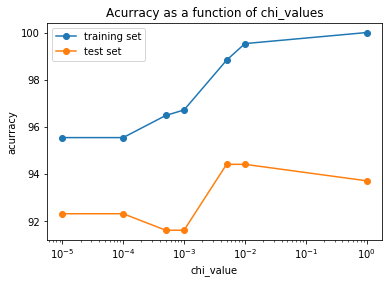

In [28]:
#### Your visualization here ####
plt.plot(p_values, training, label='training set', marker='o')
plt.plot(p_values, testing, label='test set', marker='o')

plt.xscale('log')
plt.xlabel('chi_value')
plt.ylabel('acurracy')
plt.title('Acurracy as a function of chi_values')
plt.legend()
plt.show()

We see that with pruning the accuracy of our training set declines but the accuracy of the test set actually increases up to chi = .005  before it starts to decline again. It increase the accuracy a tiny bit because we're reducing our chances of overfitting the training data.

## Post pruning

Construct a decision tree without Chi square pruning. For each leaf in the tree, calculate the test accuracy of the tree assuming no split occurred on the parent of that leaf and find the best such parent (in the sense that not splitting on that parent results in the best testing accuracy among possible parents). Make that parent into a leaf and repeat this process until you are left with just the root. On a single plot, draw the training and testing accuracy as a function of the number of internal nodes in the tree. Explain the results: what would happen to the training and testing accuracies when you remove nodes from the tree? Can you suggest a different approach to achieve better results?

In [ ]:
#### Your code here ####

Your answer here

## Print the tree

Complete the function `print_tree` in the python file `hw2.py` and print the tree using the chosen impurity measure and no pruning. Your code should like something like this:
```
[X0 <= 1],
  [X1 <= 2]
    [X2 <= 3], 
       leaf: [{1.0: 10}]
       leaf: [{0.0: 10}]
    [X4 <= 5], 
       leaf: [{1.0: 5}]
       leaf: [{0.0: 10}]
   leaf: [{1.0: 50}]
```

where the number after X is the column index of the feature and the value is the threshold used to split the data
of that node.

In [ ]:
#### Your code here ####